# Learning Rate Range Test on CIFAR-10 with keras

This notebook uses the [keras](https://keras.io/) library. 

It is meant to reproduce the learning rate range test that fastai published [in this notebook](https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb) and presented in [this blog post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6).

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Set seeds for reproducibility

In [5]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## fastai reference result

The tests are run on cifar 10 with an SGD optimizer finding the result in the following picture and selecting a final range of 0.08 - 0.8 (to 3).

In [27]:
from IPython.display import Image
Image(url="https://miro.medium.com/max/346/1*aSQd2ZN4Kl3DXPJzw3kTpQ.jpeg", width=600, height=300)

## LRRT Tests

In [6]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os

from lr_finder_tools.model_architectures import build_classification_model
from lr_finder_tools.lr_finder import LRFinder
from lr_finder_tools.weight_decay import set_weight_decay
from lr_finder_tools.img_augmentation import get_cifar_data
from lr_finder_tools.utils import set_optimizer
from lr_finder_tools.visualization import plot_lr_loss, plot_lrrt_curves_by_max_lr, stack_tests

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [20]:
def multiple_runs_lr_find(n, data_gen, model, reload_weights=False, filepath='./lr_find_data.pkl'):
    all_losses = []
    all_min_lr = []
    all_max_lr = []

    lr_finder = LRFinder(min_lr=MIN_LR, max_lr=MAX_LR,
                 batches_lr_update=BATCHES_LR_UPDATE,
                 reload_weights=True)
    
    for i in range(n):

        if reload_weights:
            model.load_weights('initial_weights.hdf5')
        else:
            model = build_classification_model(architecture, num_classes, input_shape, 'he_uniform')
            set_weight_decay(model, alpha=WEIGHT_DECAY)
            
        opt = set_optimizer(optimizer=OPTIMIZER, lr=MIN_LR, mom=MOMENTUM)
        model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        model.fit_generator(data_gen,
                            steps_per_epoch=NUM_ITERATIONS_PER_EPOCH,
                            epochs=NUM_EPOCHS,
                            callbacks=[lr_finder],
                            shuffle=True)

        losses = lr_finder.losses
        min_lr = lr_finder.min_lr_suggested
        max_lr = lr_finder.max_lr_suggested

        all_losses.append(losses)
        all_min_lr.append(min_lr)
        all_max_lr.append(max_lr)


    lrs = lr_finder.learning_rates

    lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = stack_tests(lrs, all_losses, all_min_lr, all_max_lr)

    with open(filepath, 'wb') as fp:
        pickle.dump([lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res], fp)
        
    return lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res

In [9]:
num_classes = 10
x_train, y_train, x_test, y_test, aug = get_cifar_data(num_classes)

n_training_samples = len(y_train)

MIN_LR = 1e-7
MAX_LR = 100
BATCH_SIZE = 512
# by default fastai has 100 iterations in lr_finder (roughly 1 epoch for cifar10)
NUM_EPOCHS = 1
NUM_ITERATIONS_PER_EPOCH = int(np.ceil(n_training_samples // BATCH_SIZE))
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
BATCHES_LR_UPDATE = 1
OPTIMIZER = 'sgd'

# build the model to train
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
architecture = 'resnet56'

rnd_gen = aug.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

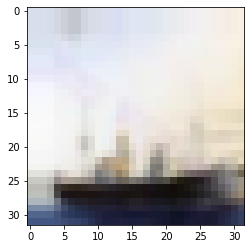

In [10]:
plt.imshow(rnd_gen.next()[0][1,:,:,:])

In [11]:
rnd_gen.reset()

In [12]:
model = build_classification_model(arch=architecture, num_classes=num_classes, input_shape=input_shape)
    
set_weight_decay(model, alpha=WEIGHT_DECAY)

opt = set_optimizer(optimizer=OPTIMIZER, lr=MIN_LR, mom=MOMENTUM)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [17]:
model.save_weights('initial_weights.hdf5')

In [18]:
N_EXPERIMENTS = 20

### Multiple runs with same weight initialization and random batch sampling

In [ ]:
lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = multiple_runs_lr_find(
    N_EXPERIMENTS, rnd_gen, model, reload_weights = True, 
    filepath='./lr_find_data_same_weights_rnd_batch.pkl')

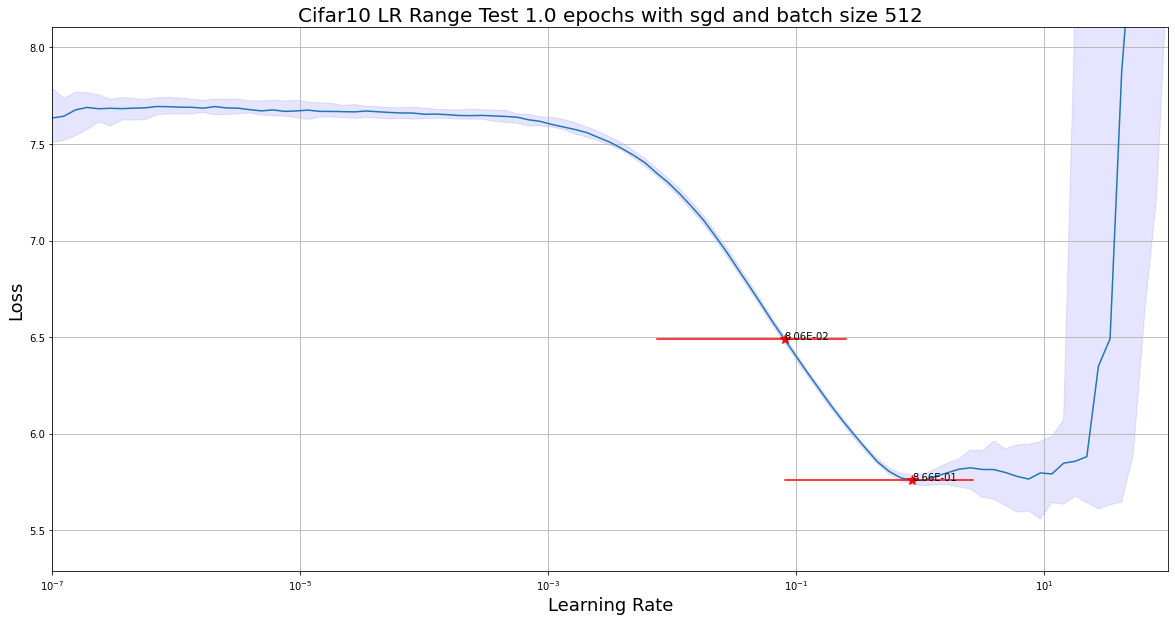

In [29]:
plot_lr_loss(lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res, '1.0', 'sgd', BATCH_SIZE, ylim_top_ratio=0.25)

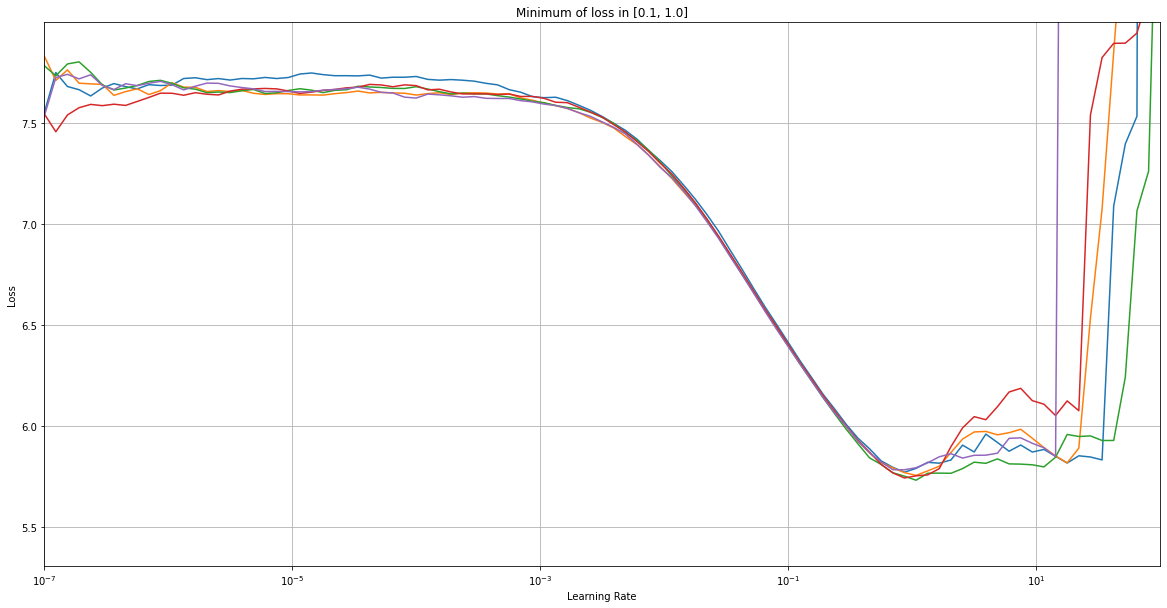

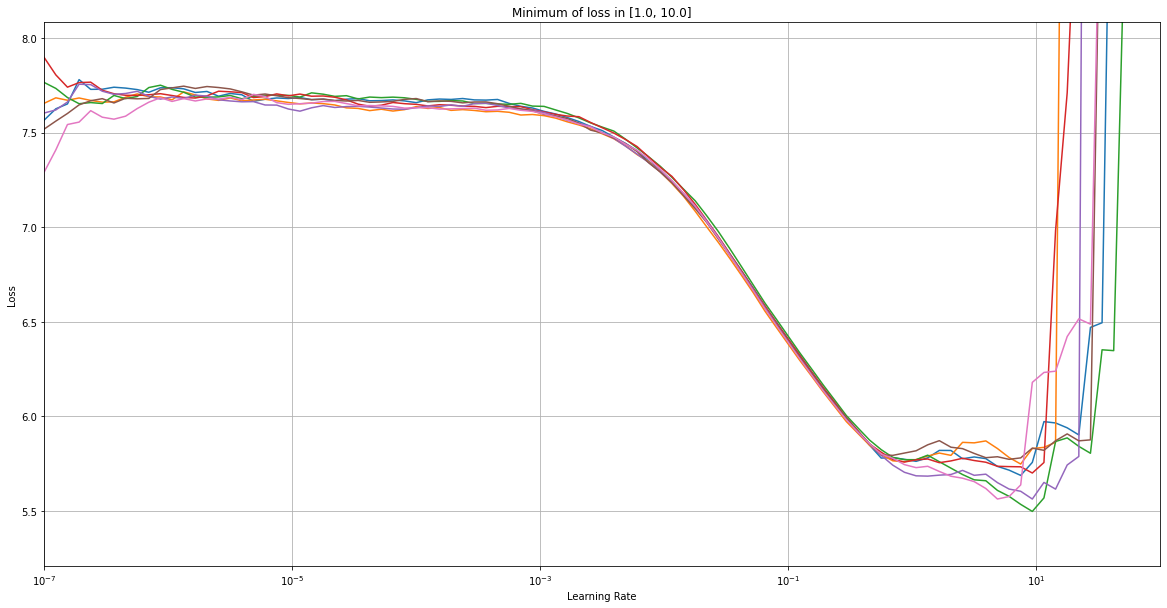

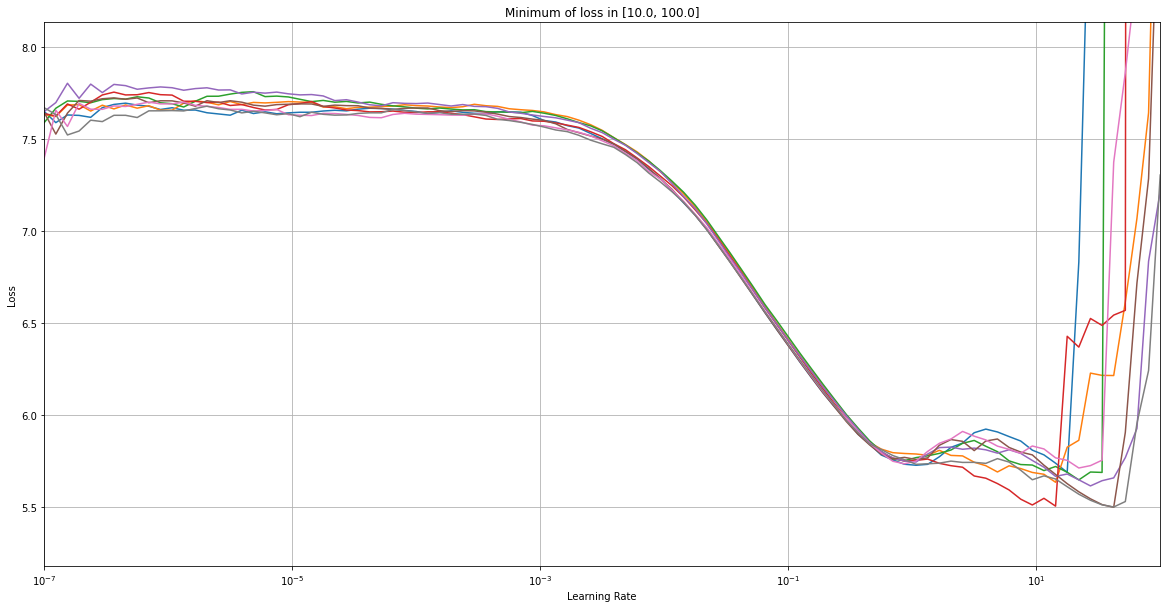

In [30]:
plot_lrrt_curves_by_max_lr(lrs_res, all_losses_res, all_max_lr_res)

### Multiple runs with different weight initialization and random batch sampling

In [ ]:
lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = multiple_runs_lr_find(
    N_EXPERIMENTS, rnd_gen, model, reload_weights = False, 
    filepath='./lr_find_data_rnd_weights_rnd_batch.pkl')

In [5]:
with open('./lr_find_data_rnd_weights_rnd_batch.pkl', 'rb') as fp:
    lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res = pickle.load(fp)

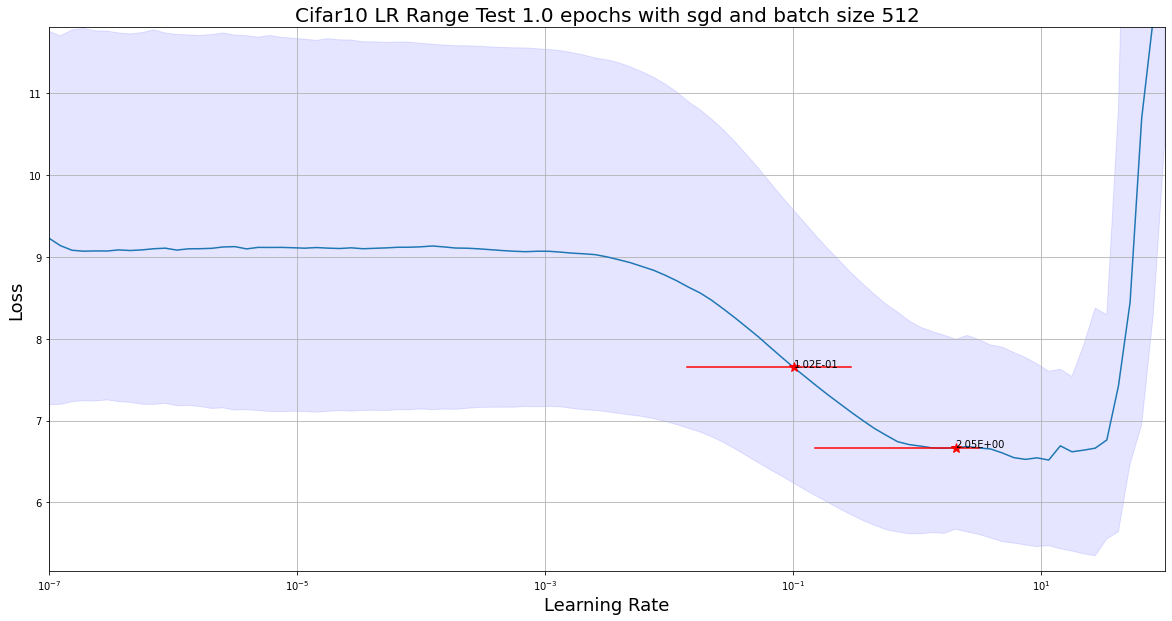

In [23]:
plot_lr_loss(lrs_res, all_losses_res, all_min_lr_res, all_max_lr_res, '1.0', 'sgd', 512)

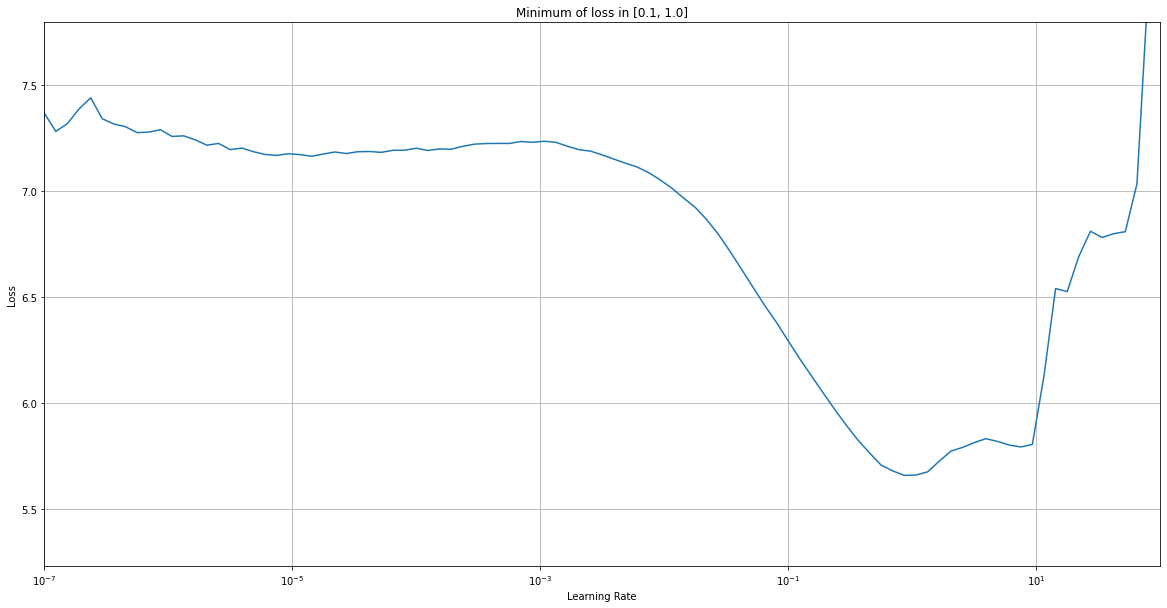

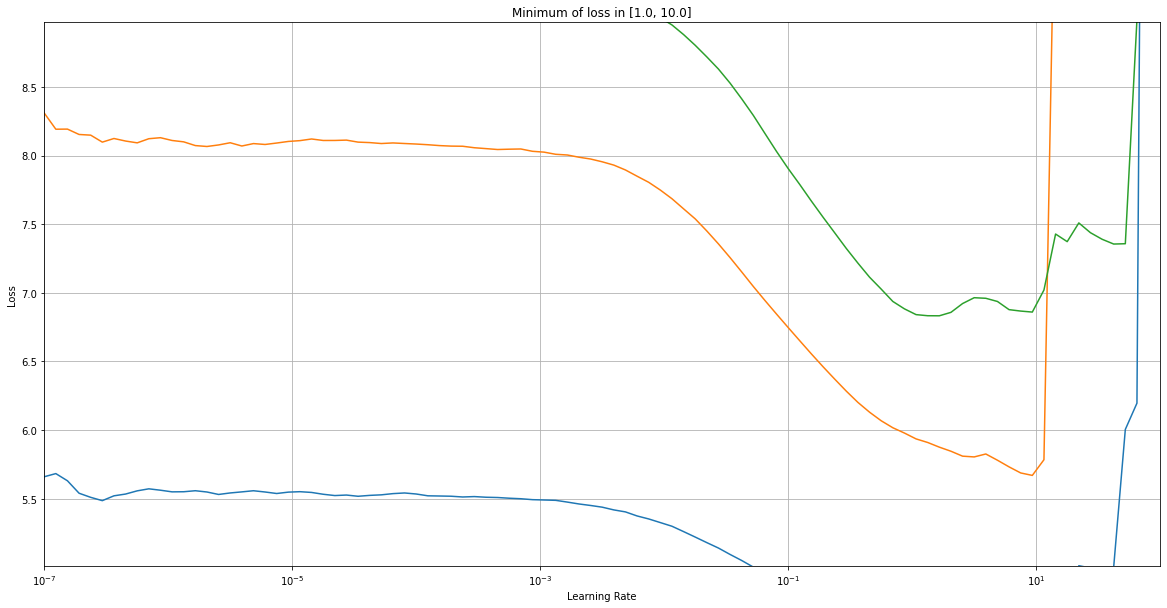

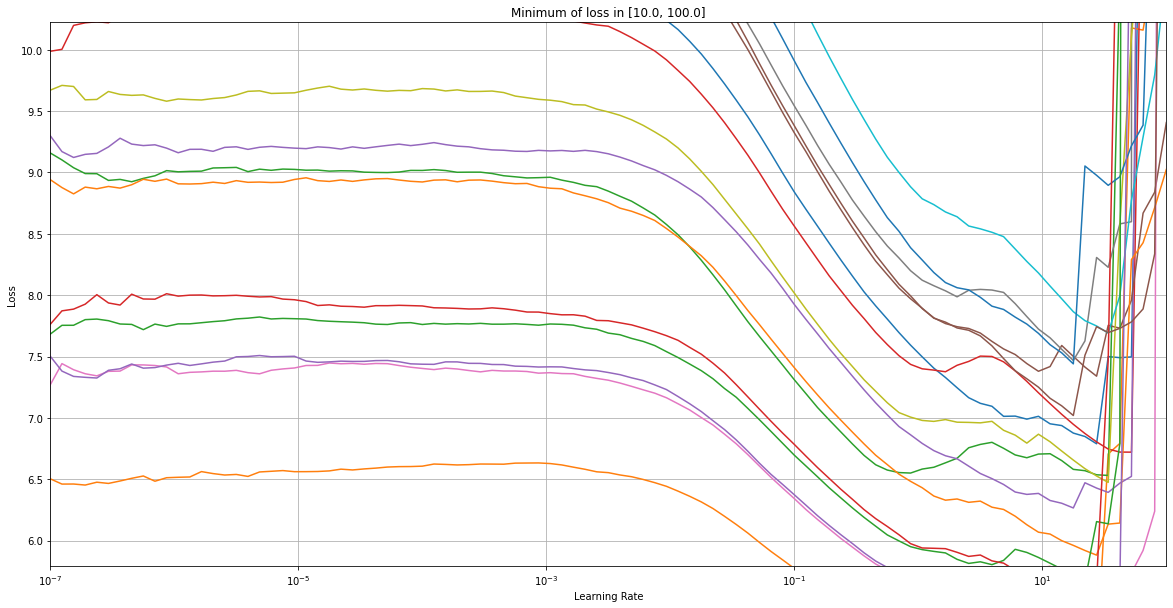

In [18]:
plot_lrrt_curves_by_max_lr(lrs_res, all_losses_res, all_max_lr_res)